# Tensorflow Music Generator
From [this tutorial](https://www.tensorflow.org/tutorials/audio/music_generation)

In [37]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import os
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [38]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [39]:
data_dir = pathlib.Path.cwd().joinpath("mids")
filenames = glob.glob(str(data_dir.joinpath("*.mid")))

In [40]:
sample_file = filenames[400]

pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# display_audio(pm)

In [ ]:
# print("Number of instruments: ", len(pm.instruments))
# # instrument = pm.instruments[0]
# # instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
# # print("Instrument name:", instrument_name)
# instrument = pm.instruments
# for ins in instrument:
#     print(pretty_midi.program_to_instrument_name(ins.program))

In [ ]:
# for i, note in enumerate(instrument.notes[:10]):
#     note_name = pretty_midi.note_number_to_name(note.pitch)
#     duration = note.end - note.start
#     print(f"{i}: pitch={note.pitch}, note_name={note_name},"
#           f"duration={duration:.4f}")

In [51]:

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    idx = 0
    for i in range(len(pm.instruments)):
        if "piano" in pretty_midi.program_to_instrument_name(pm.instruments[i].program).lower():
            print("yes", i)
            idx = i
            break
    instrument = pm.instruments[idx]
    notes = collections.defaultdict(list)
    
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes["pitch"].append(note.pitch)
        notes["start"].append(start)
        notes["end"].append(end)
        notes["step"].append(start - prev_start)
        notes["duration"].append(end - start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [42]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,65,7.155954,8.780955,0.000000,1.625001
1,62,7.155954,8.780955,0.000000,1.625001
2,58,7.155954,8.780955,0.000000,1.625001
3,55,7.155954,8.780955,0.000000,1.625001
4,67,8.792860,10.221432,1.636905,1.428572


In [43]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['F4', 'D4', 'A#3', 'G3', 'G4', 'E4', 'D5', 'A#3', 'C5', 'A3'],
      dtype='<U3')

In [44]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f"First {count} notes"
    else:
        title = f"Whole track"
        count = len(notes["pitch"])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes["pitch"], notes["pitch"]], axis=0)
    plot_start_stop = np.stack([notes["start"], notes["end"]], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel("Time [s]")
    plt.ylabel("Pitch")
    _ = plt.title(title)

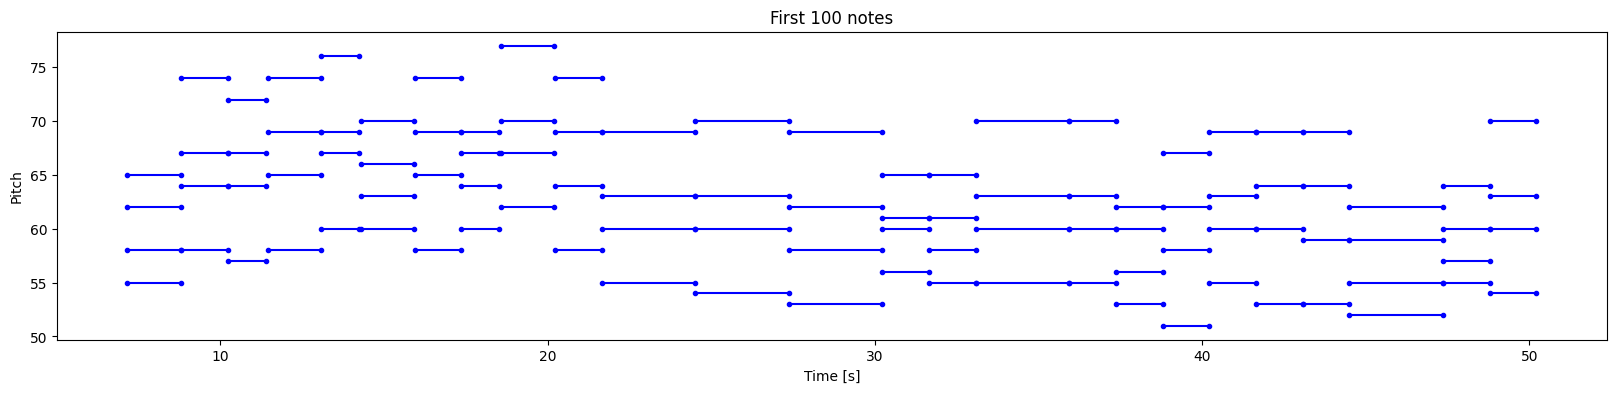

In [45]:
plot_piano_roll(raw_notes, count=100)

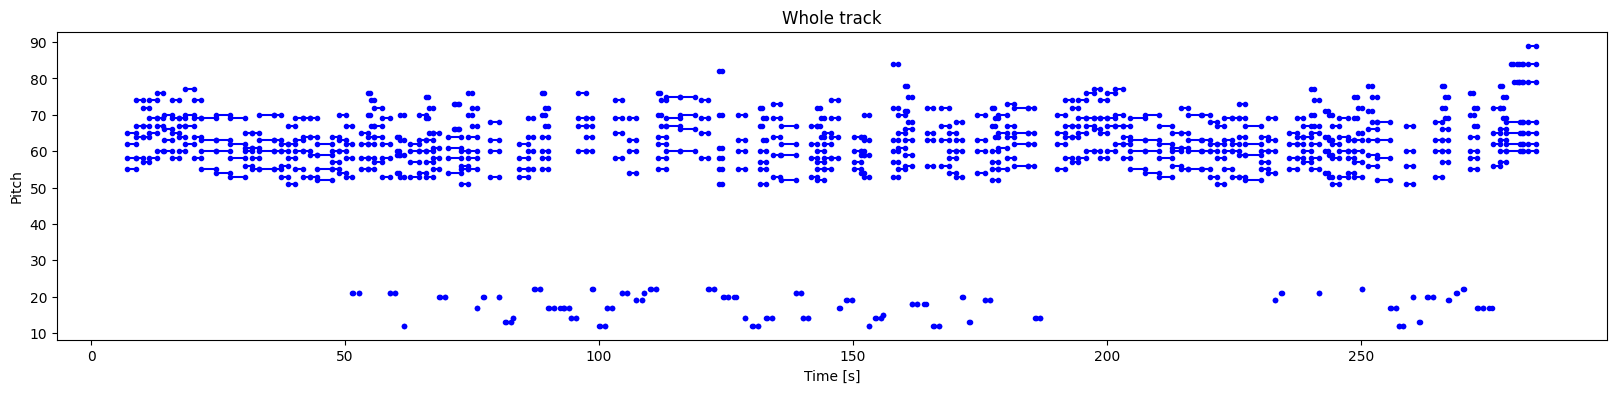

In [46]:
plot_piano_roll(raw_notes)

In [47]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes["step"], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes["duration"], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

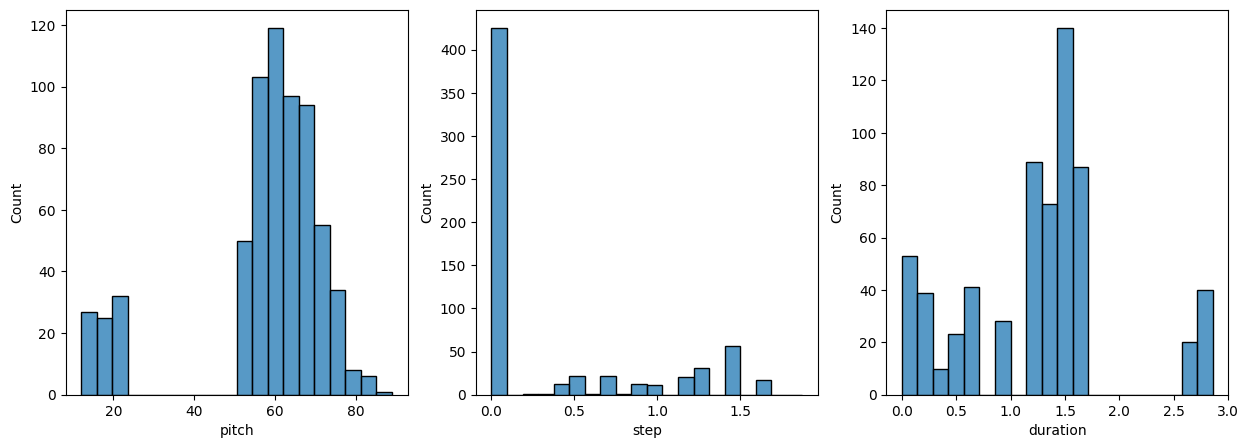

In [48]:
plot_distributions(raw_notes)

In [49]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,
) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note["step"])
        end = float(start + note["duration"])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note["pitch"]),
            start=start,
            end=end,
        )
        
    instrument.notes.append(note)
    pm.write(out_file)
    return pm

In [52]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

yes 0
yes 3
yes 5
yes 1


In [53]:
n_notes = len(all_notes)
print("Number of notes parsed:", n_notes)

Number of notes parsed: 3814
